# Imports

In [26]:
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() #sets the matplotlib style to seaborn style

from scipy.io import loadmat 
from scipy.ndimage import convolve1d
from scipy.signal import butter
from scipy.signal import sosfiltfilt
from scipy.signal import welch
import pandas as pd

PROJECT_ROOT = Path(os.path.abspath(__file__)).parent if '__file__' in globals() else Path.cwd()
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
EMG_DIR = os.path.join(DATA_DIR, "EMG")
OUT_DIR = os.path.join(PROJECT_ROOT, "output")

EMG_OUTPUT_DIR = os.path.join(OUT_DIR, "emg")
os.makedirs(EMG_OUTPUT_DIR, exist_ok=True)

# Part 1: Single subject classification

## Loading data

In [3]:
s2_dir = Path(EMG_DIR) / 's2'

mat_files = sorted(s2_dir.glob('S2_*.mat'))
print(f'found {len(mat_files)} .mat files for subject 2')
for f in mat_files:
    m = loadmat(f, squeeze_me=True)
    keys = [k for k in m.keys() if not k.startswith('__')]
    print(f'\n{f.name}: keys -> {keys}')
    emg_key = next((k for k in keys if 'emg' in k.lower()), None)
    if emg_key:
        emg = m[emg_key]
        print(f'  {emg_key} shape: {np.shape(emg)}')
    restimulus = m.get('restimulus', None)
    if restimulus is not None:
        rs = np.asarray(restimulus).ravel()
        print(f'  unique stimulus labels: {np.unique(rs)}')
    rerepetition = m.get('rerepetition', None)
    if rerepetition is not None:
        rr = np.asarray(rerepetition).ravel()
        print(f'  repetitions: {np.unique(rr)}')

# Save only exercise 1 for subject 2
s2_dir = Path(EMG_DIR) / 's2'
ex1_file = sorted(s2_dir.glob('S2_A1_E1.mat'))
if not ex1_file:
    raise FileNotFoundError('S2_A1_E1.mat not found under EMG_DIR/s2')
ex1_path = ex1_file[0]
mat_ex1 = loadmat(ex1_path, squeeze_me=True)

subject = np.asarray(mat_ex1.get('subject')) if 'subject' in mat_ex1 else None
exercise = np.asarray(mat_ex1.get('exercise')) if 'exercise' in mat_ex1 else None
stimulus = np.asarray(mat_ex1.get('stimulus')) if 'stimulus' in mat_ex1 else None
restimulus = np.asarray(mat_ex1.get('restimulus')) if 'restimulus' in mat_ex1 else None
repetition = np.asarray(mat_ex1.get('repetition')) if 'repetition' in mat_ex1 else None
rerepetition = np.asarray(mat_ex1.get('rerepetition')) if 'rerepetition' in mat_ex1 else None
emg_ex1 = np.asarray(mat_ex1['emg'])
glove = np.asarray(mat_ex1.get('glove')) if 'glove' in mat_ex1 else None
fs_val = mat_ex1.get('fs', None)
fs_ex1 = float(np.asarray(fs_val).squeeze()) if fs_val is not None else 100.0

out_path = s2_dir / 's2_ex1_raw.npz'
np.savez(
    out_path,
    subject=subject,
    exercise=exercise,
    stimulus=stimulus,
    restimulus=restimulus,
    repetition=repetition,
    rerepetition=rerepetition,
    emg=emg_ex1,
    glove=glove,
    fs=fs_ex1,
)
print(f'\nsaved exercise 1 to {out_path}')

found 3 .mat files for subject 2

S2_A1_E1.mat: keys -> ['subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']
  emg shape: (100686, 10)
  unique stimulus labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
  repetitions: [ 0  1  2  3  4  5  6  7  8  9 10]

S2_A1_E2.mat: keys -> ['subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']
  emg shape: (142731, 10)
  unique stimulus labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
  repetitions: [ 0  1  2  3  4  5  6  7  8  9 10]

S2_A1_E3.mat: keys -> ['subject', 'exercise', 'stimulus', 'emg', 'glove', 'restimulus', 'repetition', 'rerepetition']
  emg shape: (229084, 10)
  unique stimulus labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
  repetitions: [ 0  1  2  3  4  5  6  7  8  9 10]

saved exercise 1 to /Users/bui/code/NX-421-project/data/EMG/s2/s2_ex1_raw.npz


### Visualize data before processing

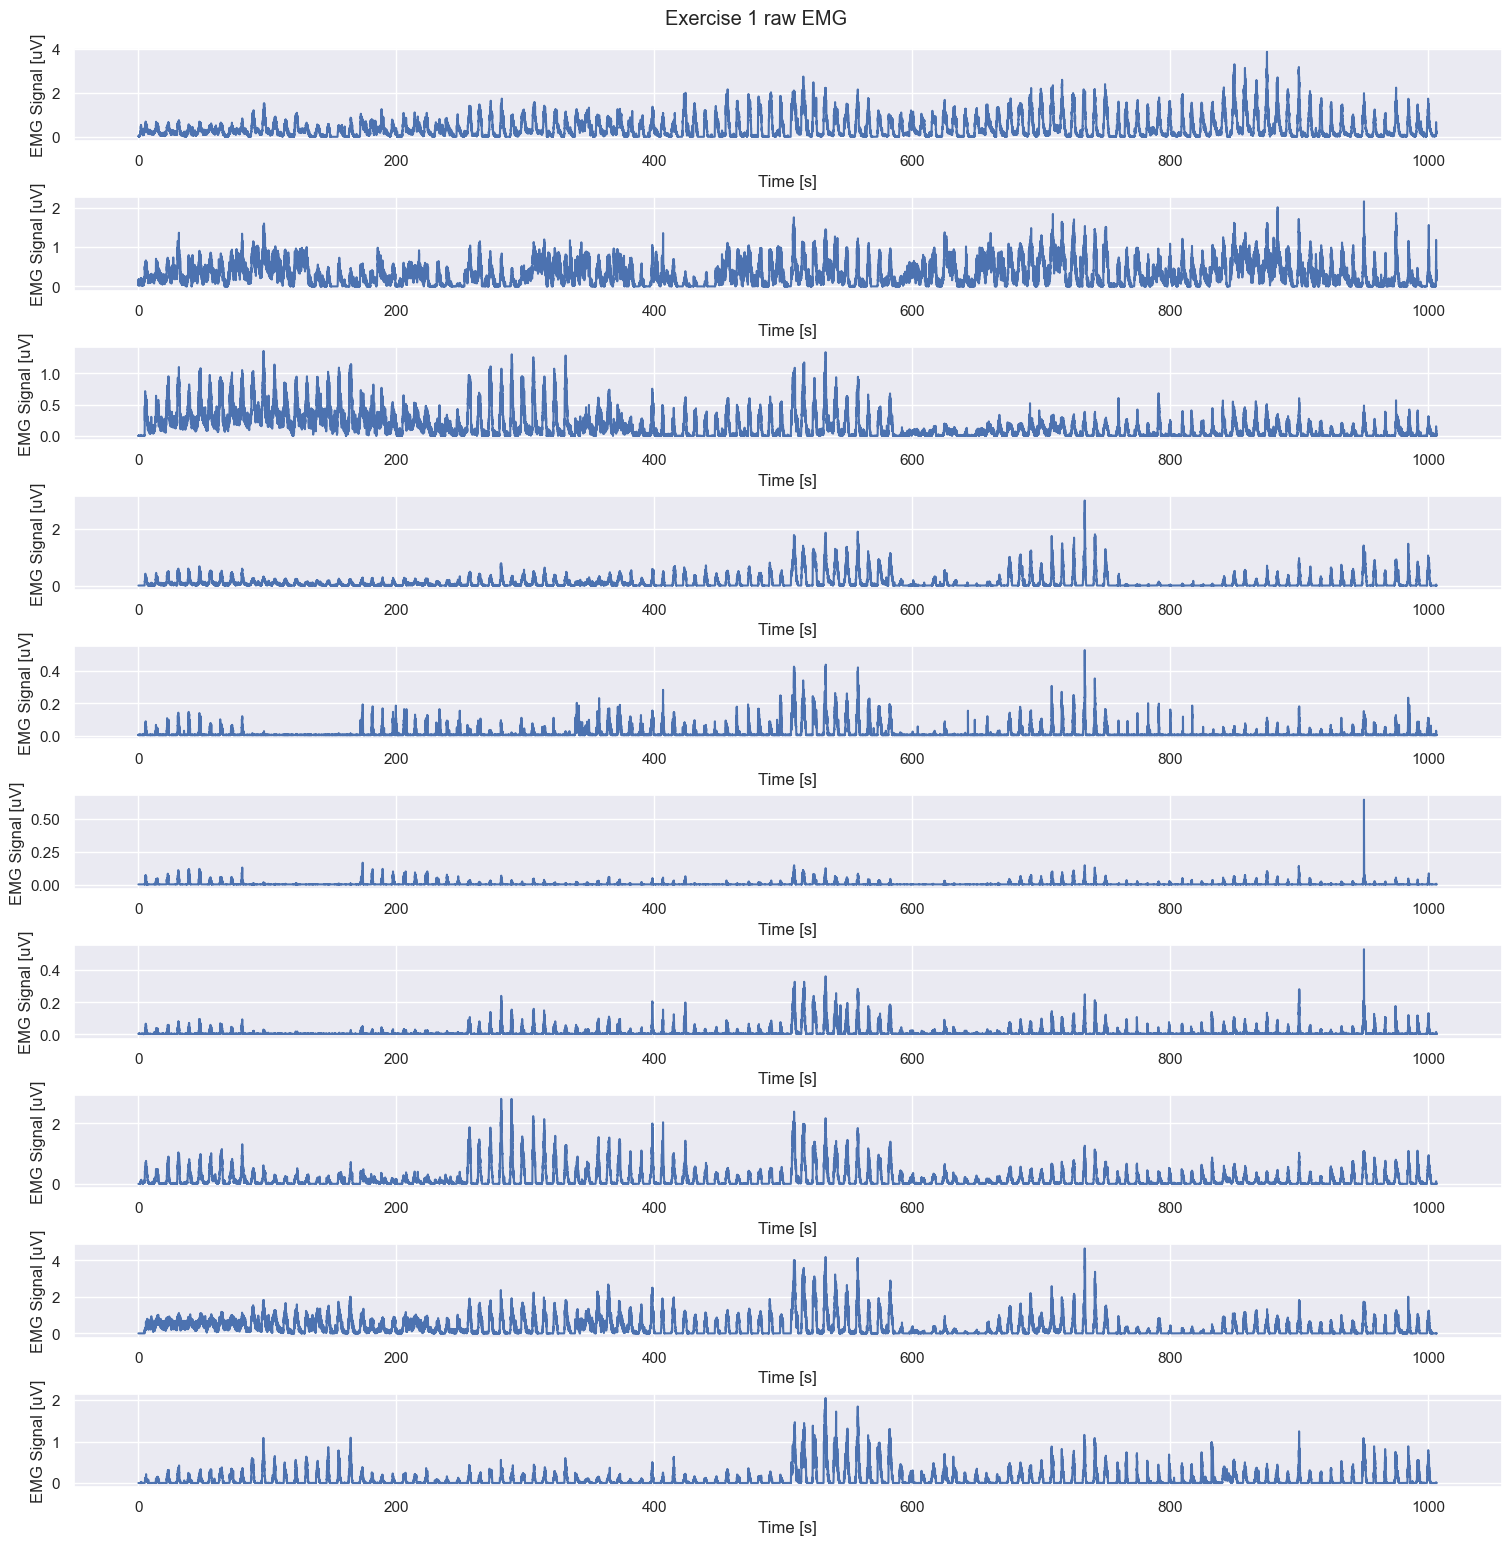

In [4]:
s2_a1_e1_path = Path(EMG_DIR) / 's2' / 's2_ex1_raw.npz'
raw = np.load(s2_a1_e1_path)
emg_raw = raw['emg']
fs = float(raw['fs'])
n_channels = emg_raw.shape[1]
time_steps = np.arange(emg_raw.shape[0]) / fs

fig, ax = plt.subplots(n_channels, 1, constrained_layout=True, figsize=(15, 15))
for channel_idx in range(n_channels):
    ax[channel_idx].plot(time_steps, emg_raw[:, channel_idx])
    ax[channel_idx].set_xlabel('Time [s]')
    ax[channel_idx].set_ylabel('EMG Signal [uV]')
fig.suptitle('Exercise 1 raw EMG', y=1.02)
plt.show()


## Preprocessing

### Low-pass filter at 1Hz to smooth the envelope

From paper: "Before performing the classification, the data from database 1 were preprocessed using a 1st order Butterworth low-pass filter with a 1 Hz cutoff frequency"

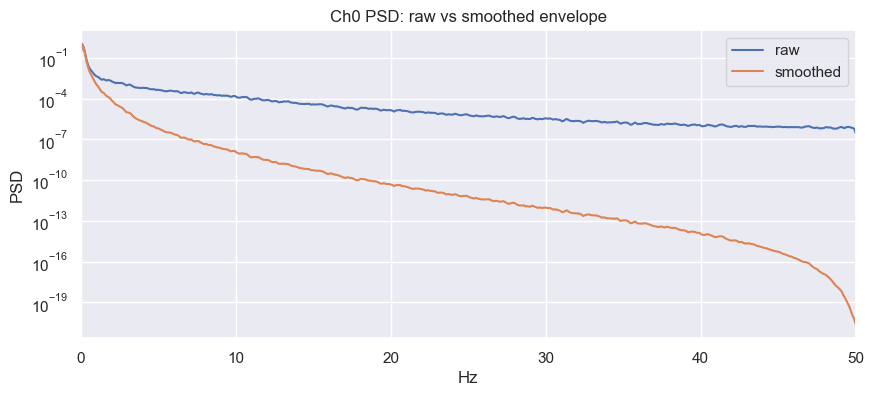

Processed data saved to /Users/bui/code/NX-421-project/output/emg/s2/s2_ex1_processed.npz


In [5]:
s2_a1_e1_path = Path(EMG_DIR) / 's2' / 's2_ex1_raw.npz'
raw = np.load(s2_a1_e1_path)
emg = raw['emg']
fs = float(raw['fs'])  # This is 100.0
n_channels = emg.shape[1]
time_steps = np.arange(emg.shape[0]) / fs

# plot PSD of raw vs smoothed on one plot
f_raw, pxx_raw = welch(emg[:, 0], fs=fs, nperseg=1024)

sos = butter(N=1, Wn=1, fs=fs, btype='low', output='sos')
emg_filtered = sosfiltfilt(sos, emg.T).T
f_filt, pxx_filt = welch(emg_filtered[:, 0], fs=fs, nperseg=1024)

plt.figure(figsize=(10, 4))
plt.semilogy(f_raw, pxx_raw, label='raw')
plt.semilogy(f_filt, pxx_filt, label='smoothed')
plt.xlim(0, 50)
plt.xlabel('Hz')
plt.ylabel('PSD')
plt.title('Ch0 PSD: raw vs smoothed envelope')
plt.grid(True)
plt.legend()
plt.show()

# 4. Save
band_out = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_processed.npz'
os.makedirs(Path(EMG_OUTPUT_DIR) / 's2', exist_ok=True)
np.savez(
    band_out,
    emg=emg_filtered,
    subject=raw.get('subject'),
    exercise=raw.get('exercise'),
    stimulus=raw.get('stimulus'),
    restimulus=raw.get('restimulus'),
    repetition=raw.get('repetition'),
    rerepetition=raw.get('rerepetition'),
    glove=raw.get('glove'),
    fs=fs,
)
print(f'Processed data saved to {band_out}')

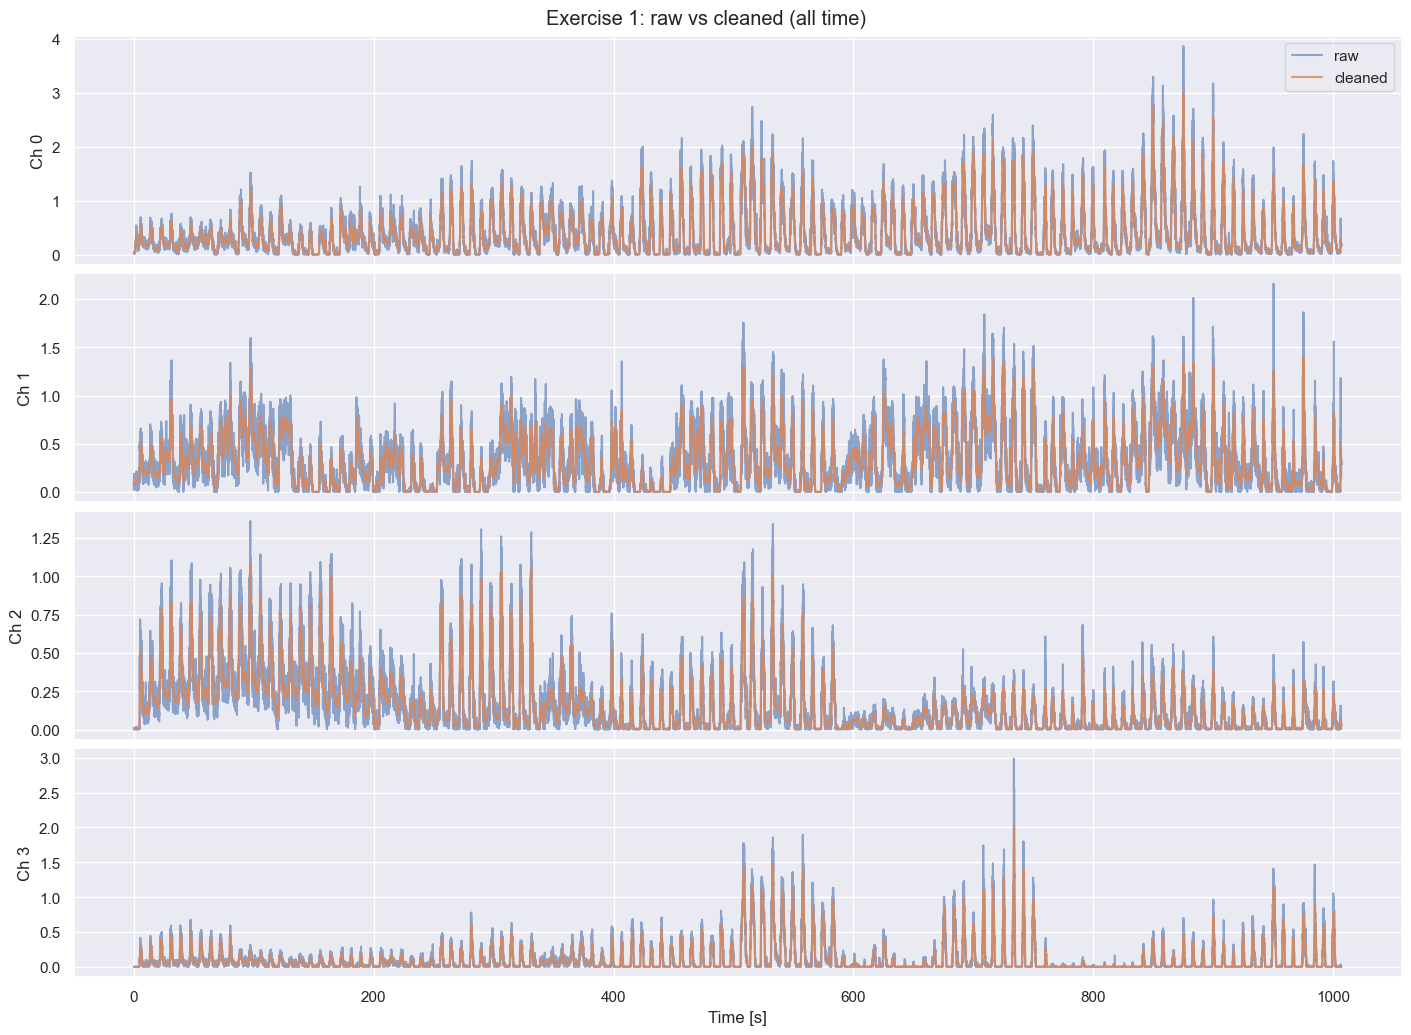

In [ ]:
# Overlay raw vs cleaned (all time, first 4 channels)
raw_path = Path(EMG_DIR) / 's2' / 's2_ex1_raw.npz'
proc_path = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_processed.npz'
raw = np.load(raw_path)
proc = np.load(proc_path)
emg_raw = raw['emg']
emg_clean = proc['emg']
fs = float(raw['fs'])
span = emg_raw.shape[0]  # Plot all samples
channels_to_plot = min(4, emg_raw.shape[1])
t = np.arange(span) / fs

fig, axes = plt.subplots(channels_to_plot, 1, figsize=(14, 10), sharex=True, constrained_layout=True)
for i in range(channels_to_plot):
    axes[i].plot(t, emg_raw[:span, i], label='raw', alpha=0.6)
    axes[i].plot(t, emg_clean[:span, i], label='cleaned', alpha=0.8)
    axes[i].set_ylabel(f'Ch {i}')
axes[-1].set_xlabel('Time [s]')
axes[0].legend()
fig.suptitle('Exercise 1: raw vs cleaned (all time)', y=1.02)
plt.show()


In [37]:
DEAD_THRESHOLD = 1e-6    # Variance below this = Dead/Flatline
ARTIFACT_THRESHOLD = 5 # Signal above this = Artifact/Explosion
STRICT_MODE = False      # True = Discard trial if ANY channel is flat. False = Just warn.

input_path = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_processed.npz'

if not input_path.exists():
    print(f"Error: File not found at {input_path}")
else:
    data = np.load(input_path)
    emg_filtered = data['emg']
    restimulus = data['restimulus']
    repetition = data['rerepetition']
    fs = data['fs']

    bad_trials_list = []

    movements = np.unique(restimulus)
    movements = movements[movements != 0] # Skip Rest (Mov 0)

    print(f"Scanning {len(movements)} movements x 10 repetitions...")

    for mov in movements:
        for rep in range(1, 11): # Only check Reps 1-10
            
            mask = (restimulus == mov) & (repetition == rep)
            trial_data = emg_filtered[mask]
            
            # Check 1: Is the trial empty?
            if len(trial_data) == 0:
                print(f"  [MISSING] Mov {mov}, Rep {rep}")
                bad_trials_list.append([mov, rep])
                continue
                
            # Check 2: Are ALL channels dead? (Sensor box off)
            trial_std = np.std(trial_data, axis=0)
            if np.all(trial_std < DEAD_THRESHOLD):
                print(f"  [ALL DEAD] Mov {mov}, Rep {rep}")
                bad_trials_list.append([mov, rep])
                continue

            # Check 3: Is ANY single channel dead? (Broken wire / Loose contact)
            dead_channels = np.where(trial_std < DEAD_THRESHOLD)[0]
            if len(dead_channels) > 0:
                msg = f"  [PARTIAL DEAD] Mov {mov}, Rep {rep} -> Ch {dead_channels + 1} are flat"
                if STRICT_MODE:
                    print(msg + " (Discarding)")
                    bad_trials_list.append([mov, rep])
                    continue
                else:
                    print(msg + " (Warning only - keeping trial)")

            # Check 4: Is there a massive artifact?
            if np.max(np.abs(trial_data)) > ARTIFACT_THRESHOLD:
                print(f"  [ARTIFACT] Mov {mov}, Rep {rep} (Amplitude explosion)")
                bad_trials_list.append([mov, rep])
                continue

    print(f"\nScan Complete. Found {len(bad_trials_list)} bad trials to discard.")

    # --- Plotting the Bad Trials ---
    if len(bad_trials_list) > 0:
        print("Plotting detected bad trials...")
        for item in bad_trials_list:
            mov, rep = item[0], item[1]
            mask = (restimulus == mov) & (repetition == rep)
            trial_data = emg_filtered[mask]
            
            if len(trial_data) > 0:
                plt.figure(figsize=(10, 4))
                plt.plot(trial_data)
                plt.title(f"BAD TRIAL: Mov {mov}, Rep {rep}")
                plt.xlabel("Time steps")
                plt.ylabel("Amplitude")
                plt.grid(True)
                plt.show()
    else:
        print("No bad trials to plot.")

    # --- Save ---
    output_path = Path(EMG_OUTPUT_DIR) / 's2' / 's2_ex1_cleaned.npz'
    np.savez(output_path, 
             emg=emg_filtered, 
             stimulus=restimulus, 
             repetition=repetition, 
             fs=fs,
             bad_trials=np.array(bad_trials_list))

    print(f"Cleaned data info saved to: {output_path}")

Scanning 12 movements x 10 repetitions...

Scan Complete. Found 0 bad trials to discard.
No bad trials to plot.
Cleaned data info saved to: /Users/bui/code/NX-421-project/output/emg/s2/s2_ex1_cleaned.npz
